# Vector Error Correction Models (VECM)

## Introdução

Neste notebook vamos apresentar algumas das funcionalidades do módulo *vecm* que auxiliam na análise de um modelo de correção de erro vetorial *(VECM)*


$\Delta y_t = \alpha \beta^T y_{t-1} + \Gamma_1 \Delta y_{t-1} + \dots +  \Gamma_{p-1} \Delta y_{t-p+1} + U_t$

Onde $ \alpha ,  \beta  \in \mathbb{R}^{K \times r} e \Gamma_i \in \mathbb{R}^{K \times K} para i=1,...,p-1$ são os parametros e $u_t$ é $K$-dimensão ruído branco. Ambos $\alpha$ e $\beta$ tem posto $r$ 
o chamado posto de cointegração.

### Bibliotecas utilizadas no código

In [32]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.vector_ar.vecm import *
import statsmodels.datasets.interest_inflation.data as d
import pandas

import warnings

warnings.filterwarnings('ignore')


### Carregamento e leituras dos dados

In [33]:
df = d.load_pandas().data
df

,year,quarter,Dp,R
0,1972.0,2.0,-0.003133,0.083
1,1972.0,3.0,0.018871,0.083
2,1972.0,4.0,0.024804,0.087
3,1973.0,1.0,0.016278,0.087
4,1973.0,2.0,0.000290,0.102
...,...,...,...,...
102,1997.0,4.0,0.024245,0.051
103,1998.0,1.0,-0.014647,0.047
104,1998.0,2.0,-0.002049,0.047
105,1998.0,3.0,0.002475,0.041


In [34]:
dates = df[["year", "quarter"]].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)
data = df[["Dp", "R"]]
data.index = pandas.DatetimeIndex(quarterly)

data

,Dp,R
1972-06-30,-0.003133,0.083
1972-09-30,0.018871,0.083
1972-12-31,0.024804,0.087
1973-03-31,0.016278,0.087
1973-06-30,0.000290,0.102
...,...,...
1997-12-31,0.024245,0.051
1998-03-31,-0.014647,0.047
1998-06-30,-0.002049,0.047
1998-09-30,0.002475,0.041


### Visualização das Series

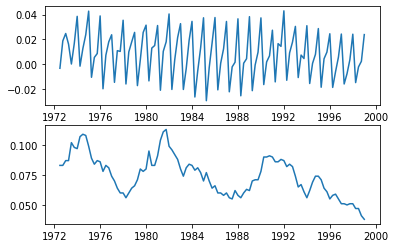

In [35]:
plt.figure()
ax = plt.subplot(211)
ax.plot(data.index, data["Dp"])
ax = plt.subplot(212)
ax.plot(data.index, data["R"])

Pelo gráficos acima, temos as duas variáveis ​​"Dp" (inflação) e "R" (juros) assim vale no nosso exemplo $K=2$

No gráfico, vemos que a variável "Dp" tem um forte efeito sazonal que consideraremos especificando seasons=4 em várias das seguintes células de entrada.

Também notamos que todas as observações de "R" são maiores que zero, portanto, incluiremos uma interceptação. Pode-se mostrar que um VECM com uma interceptação pode ser escrito como:

### Especificação do modelo

Busca do ordem do Lag a ser utilizado do modelo

In [36]:
lag_order = select_order(data=data, maxlags=10, deterministic="ci", seasons=4)
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,-20.74,-20.37*,9.838e-10,-20.59*
1,-20.73,-20.25,9.984e-10,-20.53
2,-20.65,-20.06,1.079e-09,-20.41
3,-20.77*,-20.08,9.561e-10*,-20.49
4,-20.71,-19.91,1.020e-09,-20.38
5,-20.68,-19.77,1.054e-09,-20.31
6,-20.64,-19.63,1.094e-09,-20.23
7,-20.59,-19.47,1.162e-09,-20.13
8,-20.52,-19.29,1.247e-09,-20.02
9,-20.51,-19.17,1.271e-09,-19.97


In [37]:
print(lag_order)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 3, BIC -> 0, FPE -> 3, HQIC ->  0>


In [38]:
lag_order.aic, lag_order.bic, lag_order.fpe, lag_order.hqic

(3, 0, 3, 0)

In [39]:
rank_test = select_coint_rank(data, 0, 3, method="trace", signif=0.05)
rank_test.rank

1

In [40]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,2,17.17,15.49
1,2,3.032,3.841


In [41]:
model = VECM(data, deterministic="ci", seasons=4,
             k_ar_diff=lag_order.aic,  # =3
             coint_rank=rank_test.rank)  # =1

In [42]:
vecm_res = model.fit()

In [43]:
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
season1,0.0162,0.005,3.554,0.000,0.007,0.025
season2,0.0177,0.005,3.690,0.000,0.008,0.027
season3,0.0341,0.005,7.464,0.000,0.025,0.043
L1.Dp,-0.3339,0.141,-2.364,0.018,-0.611,-0.057
L1.R,0.0677,0.095,0.715,0.474,-0.118,0.253
L2.Dp,-0.3874,0.114,-3.399,0.001,-0.611,-0.164
L2.R,-0.0030,0.095,-0.032,0.975,-0.190,0.184
L3.Dp,-0.3457,0.076,-4.524,0.000,-0.495,-0.196
L3.R,0.0204,0.092,0.222,0.824,-0.160,0.201
,coef,std err,z,P>|z|,[0.025,0.975]


In [44]:
vecm_res.alpha

array([[-0.63174988],
       [ 0.39724572]])

In [45]:
vecm_res.stderr_alpha

array([[0.16663211],
       [0.17693968]])

In [46]:
vecm_res.predict(steps=5)

array([[-0.02236238,  0.03961484],
       [-0.00390943,  0.04075971],
       [ 0.00331985,  0.04018359],
       [ 0.02437677,  0.03881549],
       [-0.02489008,  0.04001414]])

In [47]:
vecm_res.predict(steps=5, alpha=0.05)
for text, vaĺues in zip(("forecast", "lower", "upper"), vecm_res.predict(steps=5, alpha=0.05)):
    print(text+":", vaĺues, sep="\n")

forecast:
[[-0.02236238  0.03961484]
 [-0.00390943  0.04075971]
 [ 0.00331985  0.04018359]
 [ 0.02437677  0.03881549]
 [-0.02489008  0.04001414]]
lower:
[[-0.03177701  0.02961783]
 [-0.01359287  0.02532279]
 [-0.00657373  0.02100911]
 [ 0.01428314  0.01575236]
 [-0.03587008  0.01341332]]
upper:
[[-0.01294775  0.04961184]
 [ 0.005774    0.05619664]
 [ 0.01321343  0.05935806]
 [ 0.03447039  0.06187863]
 [-0.01391009  0.06661495]]


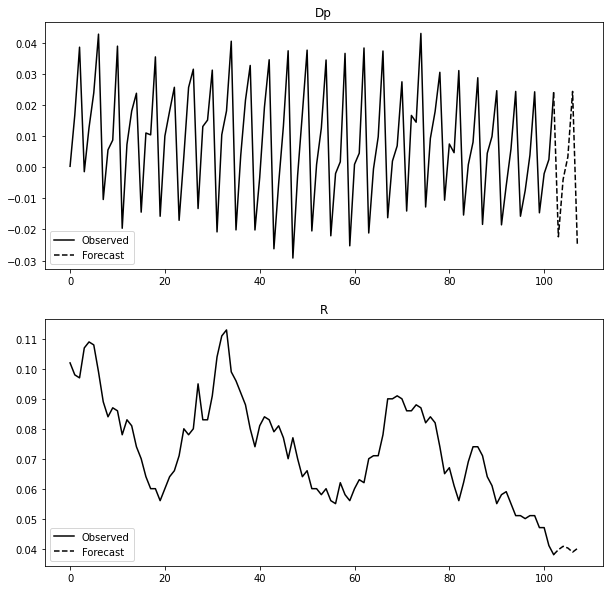

In [48]:

vecm_res.plot_forecast(steps=5, plot_conf_int=False)

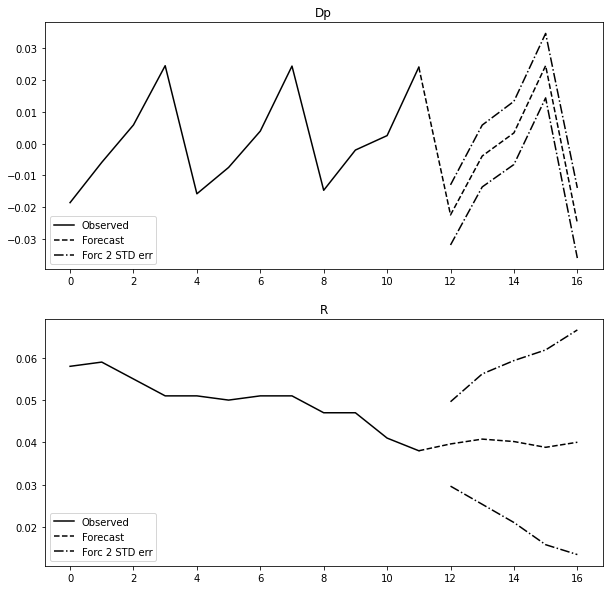

In [49]:
vecm_res.plot_forecast(steps=5, n_last_obs=12)

In [50]:
print(vecm_res.var_rep[0])  # A_1
vecm_res.var_rep

[[0.03433973 0.22617928]
 [0.19486172 1.17273842]]


array([[[ 0.03433973,  0.22617928],
        [ 0.19486172,  1.17273842]],

       [[-0.0535351 , -0.07072214],
        [-0.01565624, -0.28875262]],

       [[ 0.04174712,  0.02343397],
        [ 0.11248905,  0.24162739]],

       [[ 0.34569836, -0.02042696],
        [ 0.1055512 , -0.22525579]]])

In [51]:
vecm_res.ma_rep(maxn=2)

array([[[ 1.        ,  0.        ],
        [ 0.        ,  1.        ]],

       [[ 0.03433973,  0.22617928],
        [ 0.19486172,  1.17273842]],

       [[-0.0082822 ,  0.20229393],
        [ 0.21955708,  1.13063646]]])

### Análise estrutural

#### Causalidade de Granger

O método test_granger_causality() permite testar a causalidade de Granger.

O objeto CausalityTestResults retornado oferece um resumo do teste por meio de seu método summary().



In [31]:
# Teste de Causalidade de Granger
granger_results = vecm_res.test_granger_causality(caused="Dp", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
3.531,2.423,0.008,"(4, 176)"


In [52]:
print(granger_results)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: R does not Granger-cause Dp: reject at 5% significance level. Test statistic: 3.531, critical value: 2.423>, p-value: 0.008>


In [53]:
granger_results.signif, granger_results.pvalue

(0.05, 0.008449053735648046)

### Causalidade instantânea

Os testes de causalidade instantânea são executados de maneira semelhante usando o método test_inst_causality(). 

Novamente, um objeto CausalityTestResults é retornado.

In [54]:
inst_caus_dp_r = vecm_res.test_inst_causality(causing="Dp")
inst_caus_r_dp = vecm_res.test_inst_causality(causing="R")
inst_caus_r_dp.summary()

Test statistic,Critical value,p-value,df
0.6068,3.841,0.436,1


Também podemos comparar objetos HypothesisTestResults (HypothesisTestResults é a classe base de CausalityTestResults).

Como a causalidade instantânea é uma relação simétrica (isso significa que os papéis das variáveis ​​causadas e causadoras podem ser trocados sem efeito), os dois testes a seguir são reconhecidos como iguais.

A causalidade de Granger não é uma relação simétrica, portanto, a troca de variáveis ​​leva a instâncias de CausalityTestResults que não são iguais.

In [55]:
inst_caus_dp_r == inst_caus_r_dp

True

In [56]:
granger_results == vecm_res.test_granger_causality(caused="R", signif=0.05)

False

### Análise de Impulso-Resposta

Para analisar como um impulso em uma variável afeta o sistema, podemos usar o método irf() e chamar o método plot do objeto retornado.

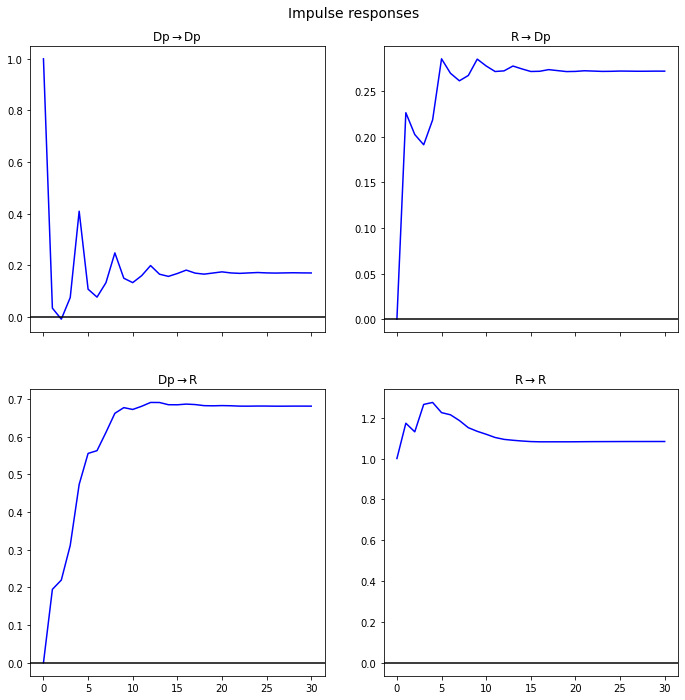

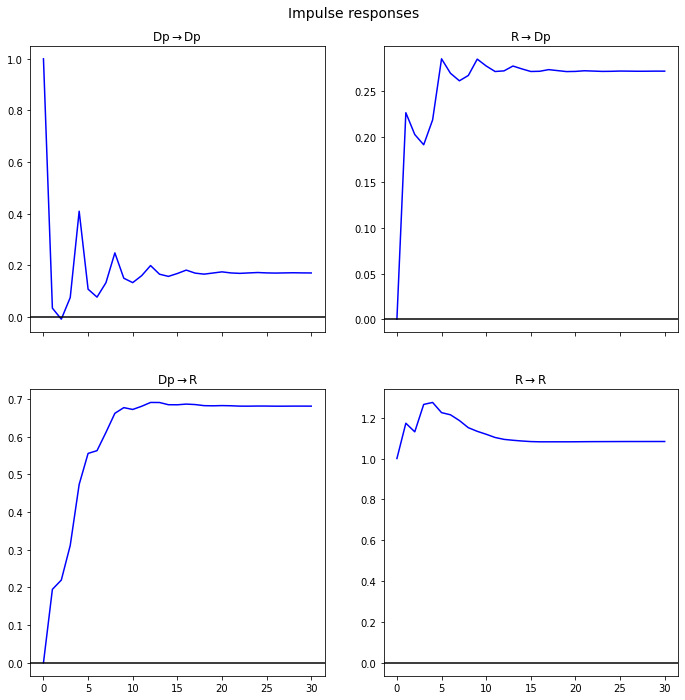

In [61]:
num_periods = 30
ir = vecm_res.irf(periods=num_periods)
ir.plot(plot_stderr=False)

###  Diagnóstico

O teste de não normalidade e de autocorrelação residual é possível com os métodos test_normality() e test_whiteness() que retornam um objeto NormalityTestResults e um objeto WhitenessTestResults, respectivamente. 

Ambas as classes mencionadas são subclasses de HypothesisTestResults - assim como no caso dos testes de causalidade. Portanto, novamente temos as mesmas possibilidades acima para inspecionar esses objetos.

### Teste de não normalidade

In [62]:
norm_test = vecm_res.test_normality()
norm_test.summary()

Test statistic,Critical value,p-value,df
2.118,9.488,0.714,4


In [63]:
print(norm_test)

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: fail to reject at 5% significance level. Test statistic: 2.118, critical value: 9.488>, p-value: 0.714>


In [64]:
norm_test.test_statistic, norm_test.crit_value, norm_test.pvalue

(2.117800919338863, 9.487729036781154, 0.7141027804379518)

### Verificando a autocorrelação residual 

In [65]:
white_test = vecm_res.test_whiteness(nlags=12, adjusted=True)
white_test.summary()

Test statistic,Critical value,p-value,df
33.52,48.60,0.491,34


In [66]:
print(white_test)

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 12 is zero: fail to reject at 5% significance level. Test statistic: 33.518, critical value: 48.602>, p-value: 0.491>


In [67]:
white_test.test_statistic, white_test.crit_value, white_test.pvalue

(33.51814228583852, 48.602367367294164, 0.49108854964096826)